In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from copy import deepcopy
from tqdm import tqdm
import random
from random import shuffle

In [2]:
import cv2
import numpy as np
import random
import os
import re
from tqdm import tqdm
from copy import deepcopy
import sys

import cv2
import numpy as np
from tqdm import tqdm
from multiprocessing import Process, Manager


In [3]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data, figsize=(16,8), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.imshow(convert_to_rgb(data.astype(int)))
    plt.title(title)
    plt.show()
    
def live_p(data, figsize=(16,8), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.show()

In [4]:
manager = Manager()  # create only 1 mgr
# prob_dict = manager.dict()

## 读取数据

In [5]:
def convert_to_rgb(img):
    img = deepcopy(img)
    b,g,r = cv2.split(img)  
    img = cv2.merge([r,g,b])
    return img

In [6]:
background = cv2.imread('../../base_data/background.jpeg')
hedge = cv2.imread('../../base_data/hedge.jpeg')

## 生成视频代码

In [7]:
def generate_video(frame_dir=None, video_dir=None, video_name='video.avi'):

    image_num = len([i for i in os.listdir(frame_dir) if '.jpg' in i])
    image_name_list = [f'{i}.jpg' for i in range(image_num)]
    frame = cv2.imread(os.path.join(frame_dir, image_name_list[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(f'{video_dir}/{video_name}', 0, 20, (width, height))

    # video = cv2.VideoWriter(f'{self.video_dir}/{video_name}', 0, 20, (width, height))

    for image in image_name_list:
        video.write(cv2.imread(os.path.join(frame_dir, image)))

    cv2.destroyAllWindows()
    video.release()

## 显示图片

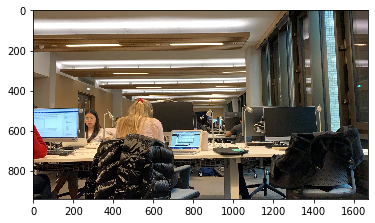

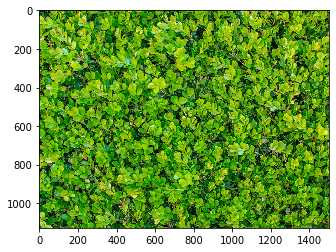

In [8]:
plt.imshow(convert_to_rgb(background))
plt.show()
plt.imshow(convert_to_rgb(hedge))
plt.show()

In [9]:
background.shape, hedge.shape

((941, 1672, 3), (1128, 1504, 3))

## 定义参数

In [10]:
speed_dict = {
    "background": 1,
    "hedge_1": 2,
    "hedge_2": 3,
    "black_bar": 4
}

crop_height = 900
crop_width = 1500
slide_width = 800
camera_width = 250

crop_width_extend = crop_width + 1000

size_1 = camera_width * 2
size_2 = slide_width

dimension = 3
black_bar_width = 10

background_prob = 0.7
noise_average_size = 10

vertical_movement = [0]
horizontal_movement = [1, 2]

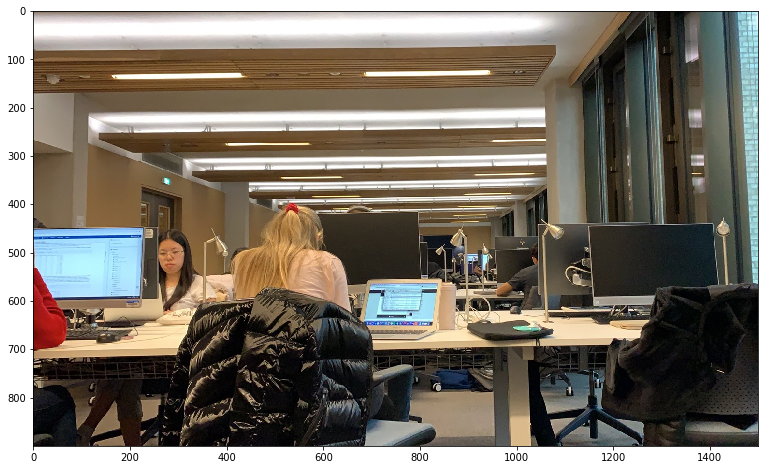

In [11]:
background_crop = deepcopy(background[-crop_height:, :crop_width, :])
live_plot(background_crop)

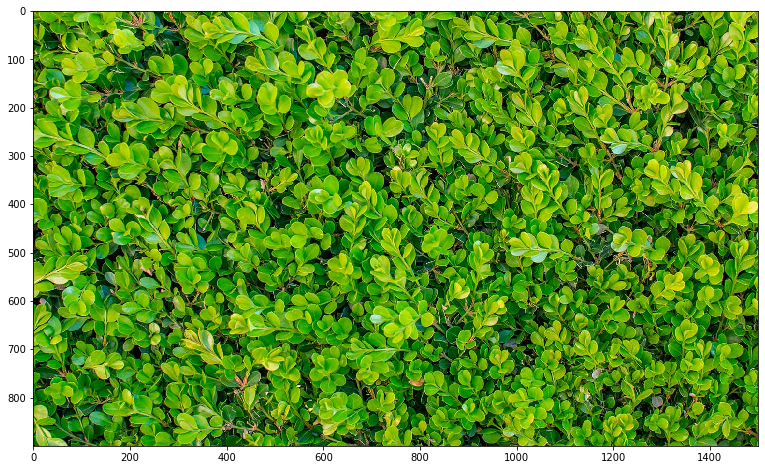

In [12]:
hedge_crop = deepcopy(hedge[-crop_height:, :crop_width, :])
live_plot(hedge_crop)

## 基于已知位移的恢复算法

In [13]:
def rgb_mean(image):
    return tuple([np.mean([np.mean(image[:, :, i])]) for i in range(2, -1, -1)])

def initialise_image(image):
    reshape_size = image.shape[0] * image.shape[1]
    a = np.zeros((dimension, reshape_size))
    for i in range(3):
        a[i] = np.array(image[:, :, i]).reshape(1, reshape_size)
    return a

def random_select():
    return random.randint(0, 250), random.randint(0, 750)

def random_radius():
    return random.randint(10, 35)

def mahalanobis(x, mean, cov):
    return np.sqrt(np.linalg.inv(cov).dot(np.transpose(x - mean)).dot((x - mean)))

def cal_ratio_prob(x):
    return 1 - (x/x.sum())

def ratio_soft_max(self, x):
    return ratio_prob(soft_max(x))

def soft_max(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [14]:
# scene_dict

In [15]:
def calculate_background_prob(pixel):
    hedge_distance = mahalanobis(pixel, hedge_mean, hedge_cov)
    top_distance = mahalanobis(pixel, background_mean, background_cov)
    ratio_prob = ratio_prob(np.array([top_distance, hedge_distance]))[0]
    return ratio_prob

def breakdown_sequence(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

def sub_cal_prob(data_set, prob_dict):
    for pixel, key in data_set:
        prob_dict[key] = calculate_background_prob(pixel)

def detect_background_pixel(frame, threshold=0.5):
    manager = Manager()  # create only 1 mgr
    prob_dict = manager.dict()

    data_set_list = []
    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            pixel = frame[i][j]
            data_set_list.append((pixel, (i, j)))

    data_set_list = breakdown_sequence(data_set_list, 16)

    process_list = []
    for data_set in data_set_list:
        p = Process(target=sub_cal_prob, args=(data_set, prob_dict))
        p.start()
        process_list.append(p)

    for p in process_list:
        p.join()

    frame_background_prob = np.zeros(frame.shape)
    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            ratio_prob = prob_dict[(i, j)]
            # ratio_prob = ratio_prob if ratio_prob > threshold else 0
            frame_background_prob[i, j, :] = ratio_prob

    return frame_background_prob

def calculate_diff(last_frame, current_frame, compare_range=3):
    current_frame_crop = deepcopy(current_frame[compare_range:-compare_range, compare_range:-compare_range, :])
    current_frame_crop_prob = detect_background_pixel(current_frame_crop)
    # current_frame_crop = np.round(current_frame_crop)

    diff_dict = {}
    shape_0, shape_1 = current_frame_crop.shape[:2]
    for i in tqdm(range(compare_range*2), ncols=70):
        for j in range(compare_range*2):
            last_frame_crop = deepcopy(last_frame[i:shape_0+i, j:shape_1+j, :])
            last_frame_crop_prob = detect_background_pixel(last_frame_crop)
            # last_frame_crop_prob = np.round(last_frame_crop_prob)

            cross_prob = (current_frame_crop_prob + last_frame_crop_prob)/2
            current_diff = np.sum((current_frame_crop - last_frame_crop) * cross_prob)/np.sum(cross_prob)

            diff_dict[(i-compare_range, j-compare_range)] = current_diff

    print(min(diff_dict, key=diff_dict.get))
    return min(diff_dict, key=diff_dict.get)    

In [16]:
def breakdown_sequence(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

In [17]:
frame_dir = '../scene_data/80'
count_img = np.zeros([size_1, size_2])
track_img = np.zeros([size_1, size_2, dimension])


hedge_mean = np.array(rgb_mean(hedge_crop))
background_mean = np.array(rgb_mean(background_crop))
hedge_cov = np.cov(initialise_image(hedge_crop))
background_cov = np.cov(initialise_image(background_crop))

scene_dict = {}
real_back_prob_list = []
for file_name in os.listdir(frame_dir):
    if file_name[0] != '.':
        num, verti_pos, hori_pos, real_back_prob = file_name.replace('.jpg', '').split('_')
        real_back_prob_list.append(int(real_back_prob))
        scene_dict[int(num)] = {'file_name': file_name, 'num':num, 'verti_pos':int(verti_pos), 'hori_pos':int(hori_pos)}
real_back_prob_mean = int(np.mean(real_back_prob_list))
    
    
    
    
num_of_scene = len([i for i in os.listdir(frame_dir) if '.jpg' in i])
test_image_dict = {}
# proba_dict = {}
pixel_dict = {}

proba_dict = manager.dict()
visit_image_dict = manager.dict()
ratio_prob_image_dict = manager.dict()
    
    
proba_dict = {}
visit_image_dict = {}
ratio_prob_image_dict = {}

threshold=0.5
ratio_prob_image = np.zeros([size_1, size_2, 3])
output_image = deepcopy(ratio_prob_image)
visit_image = deepcopy(ratio_prob_image)

offset = 150
t_pos = 0
last_frame = None
count = 0

# manager = Manager()


def calculate_background_prob(sub_rank_list):
    
    for _, pos in sub_rank_list:
        i, j = pos

        vertical_pos = int(verti_pos + i)
        horizontal_pos = int(hori_pos + j)
        key = (vertical_pos, horizontal_pos)
        pixel = frame[i][j]
        hedge_distance = mahalanobis(pixel, hedge_mean, hedge_cov)
        top_distance = mahalanobis(pixel, background_mean, background_cov)
        ratio_prob = cal_ratio_prob(np.array([top_distance, hedge_distance]))[0]
#         proba_dict[key] = proba_dict.get(key, {})
        
        ratio_prob = ratio_prob if ratio_prob > threshold else 0

        if ratio_prob > 0:
            temp_pixel = deepcopy(ratio_prob_image[vertical_pos, horizontal_pos, :])
            temp_prob = proba_dict.get(key, 0)

            
            if proba_dict.get(key, 0) > 0:
                pixel_before = temp_pixel/proba_dict.get(key, 0)
                pixel_after = (temp_pixel + pixel * ratio_prob)/(proba_dict.get(key, 0) + ratio_prob)
                before_distance = mahalanobis(pixel_before, background_mean, background_cov)
                after_distance = mahalanobis(pixel_after, background_mean, background_cov)
            else:
                before_distance = 1
                after_distance = 0

            if after_distance < before_distance or before_distance != before_distance:
                proba_dict[key] = proba_dict.get(key, 0) + ratio_prob
                ratio_prob_image_dict[key] = ratio_prob_image_dict.get(key, 0) + pixel * ratio_prob
                visit_image_dict[key] = visit_image_dict.get(key, 0) + 1


In [18]:
frame_num = 2

In [19]:
random_entry = np.random.choice(len(list(scene_dict.keys())), size=frame_num, replace=False)
scene_dict = {k:scene_dict[k] for k in random_entry}

In [20]:
scene_dict.keys()

dict_keys([75, 123])

In [21]:
# num = 0
# file_name = scene_dict[num]['file_name']
# verti_pos = scene_dict[num]['verti_pos'] - 350
# hori_pos = scene_dict[num]['hori_pos']
# frame = np.array(cv2.imread(f"{frame_dir}/{file_name}"))


In [22]:
# for i in range(frame.shape[0]):
#     for j in range(frame.shape[1]):
#         pixel = frame[i][j]
#         hedge_distance = mahalanobis(pixel, hedge_mean, hedge_cov)
#         top_distance = mahalanobis(pixel, background_mean, background_cov)
#         ratio_prob = cal_ratio_prob(np.array([top_distance, hedge_distance]))[0]   
#         if ratio_prob <= 0.5:
#             frame[i][j] = np.zeros(pixel.shape)

In [23]:
# cv2.imwrite(f"sample.jpg", frame)

In [24]:
# plt.imshow(convert_to_rgb(frame))

In [25]:
verti_pos = int(background_crop.shape[0]/2)
hori_pos = 0
upper, lower = verti_pos + camera_width, verti_pos - camera_width
background_pos = int(0 * hori_pos)
background_crop_temp = background_crop[int(lower):int(upper), background_pos:background_pos + slide_width, :]


In [26]:
# visit_image_dict_dummy = {k:v for k,v in visit_image_dict.items()}
# proba_dict_dummy = {k:v for k,v in proba_dict.items()}
# ratio_prob_image_dict_dummy = {k:v for k,v in ratio_prob_image_dict.items()}

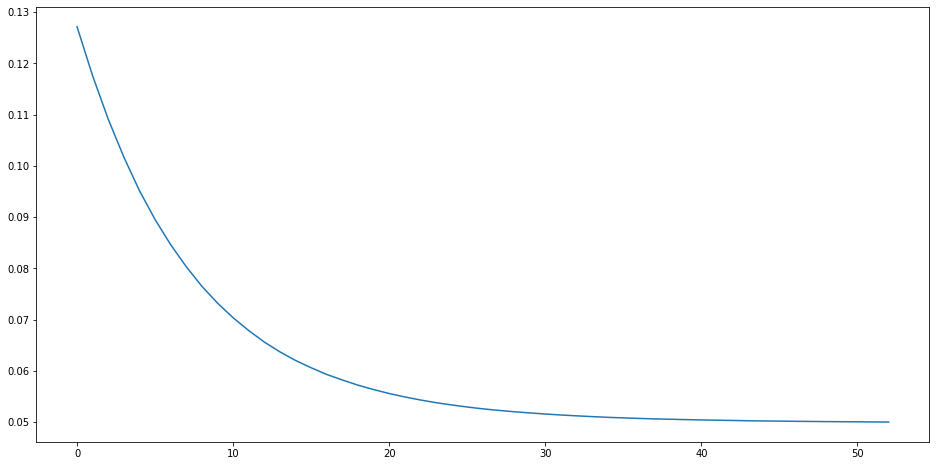

  1%|▏                    | 5232/500000 [1:03:48<109:34:12,  1.25it/s]

In [ ]:
diff_list = []

for num in tqdm([random.choice(list(scene_dict.keys())) for _ in range(500000)], ncols=70):
    file_name = scene_dict[num]['file_name']
    verti_pos = scene_dict[num]['verti_pos'] - 450
    hori_pos = scene_dict[num]['hori_pos']
    frame = np.array(cv2.imread(f"{frame_dir}/{file_name}"))

    for _ in range(1000):
        i, j = random.choice(range(frame.shape[0])), random.choice(range(frame.shape[1]))

        vertical_pos = int(verti_pos + i)
        horizontal_pos = int(hori_pos + j)
        key = (vertical_pos, horizontal_pos)
        pixel = frame[i][j]
        hedge_distance = mahalanobis(pixel, hedge_mean, hedge_cov)
        top_distance = mahalanobis(pixel, background_mean, background_cov)
        ratio_prob = cal_ratio_prob(np.array([top_distance, hedge_distance]))[0]        
        ratio_prob = ratio_prob if ratio_prob > threshold else 0

        if ratio_prob > 0:
            proba_dict[key] = proba_dict.get(key, 0) + ratio_prob
            ratio_prob_image_dict[key] = ratio_prob_image_dict.get(key, 0) + pixel * ratio_prob
            visit_image_dict[key] = visit_image_dict.get(key, 0) + 1
        
    for k, v in ratio_prob_image_dict.items():
        vertical_pos, horizontal_pos = k
        ratio_prob_image[vertical_pos, horizontal_pos, :] = v
        
    for k, v in visit_image_dict.items():
        vertical_pos, horizontal_pos = k
        visit_image[vertical_pos, horizontal_pos, :] = v
    
    n = 100
#     prob_dict_keys = list(proba_dict.keys())
    if count % n == 0:
        output_image = deepcopy(ratio_prob_image)
        for i, j in proba_dict:
            if proba_dict[(i, j)] > 0:
                output_image[i, j] = output_image[i, j] / proba_dict[(i, j)]
        
        directory = f'../recover_data/{real_back_prob_mean}_{frame_num}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        cv2.imwrite(f"{directory}/{int(count/n)}.jpg", output_image)
        diff_array = (background_crop_temp - output_image).reshape(-1,1)
        diff = np.sqrt(np.sum(np.power(diff_array,2)))/len(diff_array)
        print(f"{directory}/{int(count/n)}.jpg")

        
        diff_list.append(diff)
        directory = f'../diff_data'
        if not os.path.exists(directory):
            os.makedirs(directory)        
        np.save(f'{directory}/{real_back_prob_mean}_{frame_num}_frame.npy', diff_list)
        print(f'{directory}/{real_back_prob_mean}_{frame_num}_frame.npy')
        live_p(diff_list)
  
    count += 1